<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/CycleGan_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning - ENSAE 2020** 

In this notebook we undertake an Image-to-Image translation using the Cycle-GANs architecture. The first section uses a simple architecture proposed in the Cycle-GAN introductory [paper](https://arxiv.org/pdf/1703.10593.pdf) and its Pytorch implementation in the following [github](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). The task is to translate from USPS to MNIST. Section 2 proposes improvements based on [(Martin Arjovsky et al., 2017)]() and computes a Wasserstein Cycle-GAN on the same task. Finally we challenge the model with a more complex database translating from Apple to Windows emoticons databases. 

## **Cycle-GANs application** : from MNIST to USPS 

This code is adapted from [yunjey](https://github.com/yunjey/) and the assignment proposed. 

#### **Import packages** 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
from torchvision import datasets, models, transforms
import os 
from six.moves.urllib.request import urlretrieve
import tarfile
import warnings
warnings.filterwarnings("ignore")

### **Preparing the data** : MNIST to USPS

In [0]:
PATH_DATA = './data/'
RESULTS_PATH = './results/'

In [0]:
os.makedirs(PATH_DATA, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size = 32
batch_size = 64
num_workers = 0
n_iters = 1000

#### Download and construct loaders for USPS and Mnist

In [0]:
def get_loader_mnist(image_size,batch_size):
    transform = transforms.Compose([
                    transforms.CenterCrop(22),
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])

    mnist_train = datasets.MNIST(root=PATH_DATA,
                                 download=True,
                                 transform=transform,
                                 train=True)
    
    mnist_test = datasets.MNIST(root=PATH_DATA,
                                download=True,
                                transform=transform,
                                train=False)

    train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                               batch_size=batch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                               batch_size=batch_size,
                                               shuffle=False)

    return train_loader, test_loader 

In [0]:
def get_loader_usps(image_size,batch_size):
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])

    usps_train = datasets.USPS(root=PATH_DATA,
                               download=True,
                               transform=transform,
                               train=True)
    
    usps_test = datasets.USPS(root=PATH_DATA, 
                              download=True, 
                              transform=transform, 
                              train=False)

    train_loader = torch.utils.data.DataLoader(dataset=usps_train,
                                                batch_size=batch_size,
                                                shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=usps_test,
                                              batch_size=batch_size,
                                              shuffle=False)

    return train_loader, test_loader 

In [0]:
M_train_loader, M_test_loader = get_loader_mnist(image_size, batch_size)

In [0]:
U_train_loader, U_test_loader = get_loader_usps(image_size, batch_size)

In [0]:
examples_mnist = enumerate(M_train_loader)
batch_idx, (example_data_mnist, example_targets_mnist) = next(examples_mnist)

examples_usps = enumerate(U_train_loader)
batch_idx, (example_data_usps, example_targets_usps) = next(examples_usps)

In [10]:
example_data_usps.shape, example_data_mnist.shape # 64 per batch, size 32x32   

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

#### Visualizing both collections

In [0]:
import matplotlib.pyplot as plt

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
    for i in range(len(example_targets_mnist)):
        if example_targets_mnist[i].item() in list_label:
            pass
        else:
            list_label.append(example_targets_mnist[i].item())
            list_images.append(example_data_mnist[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

MNIST Collection :


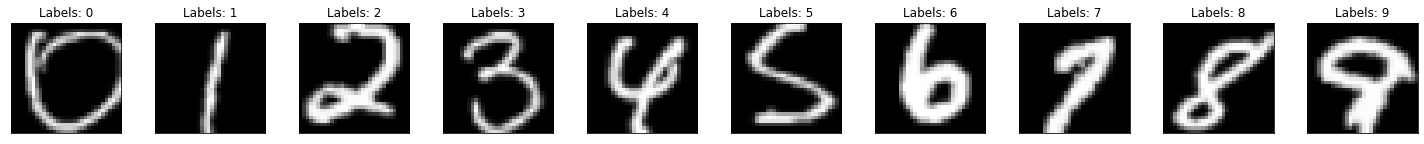

In [13]:
print("MNIST Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(list_label[i]))
    plt.xticks([])
    plt.yticks([])

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
    for i in range(len(example_targets_usps)):
        if example_targets_usps[i].item() in list_label:
            pass
        else:
            list_label.append(example_targets_usps[i].item())
            list_images.append(example_data_usps[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

USPS Collection :


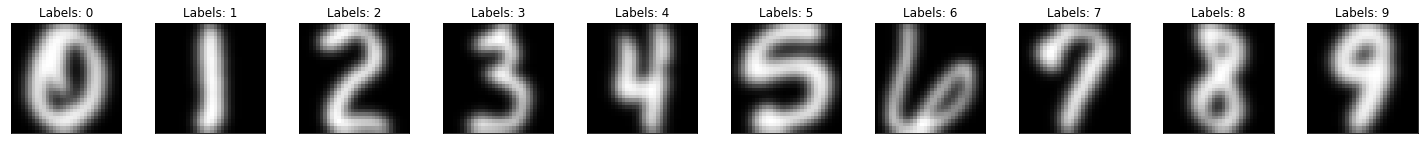

In [15]:
print("USPS Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(list_label[i]))
    plt.xticks([])
    plt.yticks([])

The USPS dataset consists of 7,291 training images and 2007 test images each of which is of the original size of 16x16. The MNIST dataset consists of 60 000 training images and 10 000 test images each of which is of the size 28x28. Both contains 10 categories (numbers from 0 to 9) and follow distinct distributions. 

### **Baseline Model Construction**

Some helper functions

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer"""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [0]:
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

#### **Discriminators**

The discriminator takes images and tries to predict if it is real of if it is fake. In this case the discriminator is just a network that search for features in the input. It consists in a series of convolutional layers

In [0]:
class D_(nn.Module):
    """Discriminator for mnist."""

    def __init__(self, conv_dim=64, sigmoid_end=True):
        super(D_, self).__init__()
        self.sigmoid_end = sigmoid_end
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)   
        out = F.leaky_relu(self.conv2(out), 0.05) 
        out = F.leaky_relu(self.conv3(out), 0.05)  
        out = self.fc(out).squeeze()
        if self.sigmoid_end:
          out=torch.sigmoid(out)
        return out

In [21]:
print('Architecture of the discriminator : ')
D_M = D_()
D_M.cuda() # This is our discriminator architecture

Architecture of the discriminator : 


D_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

An example of one batch passing through the discriminator : 

In [0]:
images_M, labels_M = iter(M_train_loader).next()
images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

In [23]:
print("Discriminator's output size : {}".format(D_M(images_M).size()))

Discriminator's output size : torch.Size([64])


In [24]:
print("Discriminator's output overview :")
D_M(images_M)

Discriminator's output overview :


tensor([0.4341, 0.4842, 0.3732, 0.6568, 0.3621, 0.3999, 0.5329, 0.5694, 0.4700,
        0.5105, 0.3625, 0.5315, 0.5140, 0.3783, 0.5134, 0.5049, 0.4414, 0.3347,
        0.5530, 0.5457, 0.5153, 0.4788, 0.6411, 0.5789, 0.4759, 0.5887, 0.4240,
        0.5045, 0.4250, 0.4682, 0.6025, 0.3965, 0.5007, 0.5206, 0.6385, 0.5823,
        0.4973, 0.5459, 0.6604, 0.4782, 0.4035, 0.3725, 0.3838, 0.5589, 0.4891,
        0.4180, 0.5224, 0.4159, 0.5147, 0.5281, 0.5239, 0.5478, 0.4384, 0.4067,
        0.4458, 0.5257, 0.5208, 0.5635, 0.4233, 0.4771, 0.4872, 0.4948, 0.4750,
        0.5398], device='cuda:0', grad_fn=<SigmoidBackward>)

#### **Generators** 

The Generator contains 3 relevants parts : 


1.   **Encoding blocks** : A convolution network that extract features from the input image with a convolutional network, just as the discriminator would do. 

2.   **Residual blocks** : This consists in a neural network layer with two convolution layers where a residue of input is added to the output. This is done to ensure properties of input of previous layers are available for later layers. We want their output not to deviate too much from original input, otherwise the characteristics of original images will not be retained in the output and results will be very abrupt. Indeed, one of the primary aim of the task we undertake is to retain the characteristics of original input and transform them.  

3.   **Decoding blocks** : deconvolution layers in the decoding blocks do the exact opposite of encoding blocks, they build back the low level features from the feature vector in order to create an image. 






In [0]:
class G_(nn.Module):
    """Generator for transfering from mnist to usps"""
    
    def __init__(self, conv_dim=64):
        super(G_, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      
        out = F.leaky_relu(self.conv2(out), 0.05)    

        out = F.leaky_relu(self.conv3(out), 0.05)    
        out = F.leaky_relu(self.conv4(out), 0.05)    

        out = F.leaky_relu(self.deconv1(out), 0.05)  
        out = torch.tanh(self.deconv2(out))            
        return out


In [26]:
# Check number of parameters in the generator
pytorch_total_params = sum(p.numel() for p in G_().parameters())
print("Number of parameters in the Generator's Network : {}".format(pytorch_total_params))

Number of parameters in the Generator's Network : 560128


#### Training loop

Utility functions

In [0]:
def print_models(G_MtoU, G_UtoM, D_M, D_U):
    """Prints model information for the generators and discriminators.
    """
    
    print("                 G_MtoU                ")
    print("---------------------------------------")
    print(G_MtoU)
    print("---------------------------------------")

    print("                 G_UtoM                ")
    print("---------------------------------------")
    print(G_UtoM)
    print("---------------------------------------")

    print("                  D_M                  ")
    print("---------------------------------------")
    print(D_M)
    print("---------------------------------------")

    print("                  D_U                  ")
    print("---------------------------------------")
    print(D_U)
    print("---------------------------------------")

In [0]:
def weights_init(m):
    """Initialization of model weights and biases
    """

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
def create_model():
    """Instantiate models, initialize their parameters,
    display their architecture, and send them to the GPU if available.
    """

    G_MtoU = G_().apply(weights_init)
    G_UtoM = G_().apply(weights_init)
    D_M = D_().apply(weights_init)
    D_U = D_().apply(weights_init)

    print_models(G_MtoU, G_UtoM, D_M, D_U)

    if torch.cuda.is_available():
        G_MtoU.cuda()
        G_UtoM.cuda()
        D_M.cuda()
        D_U.cuda()
        print('Models moved to GPU.')

    return G_MtoU, G_UtoM, D_M, D_U

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """

    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2]) # 3

    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
        
    return merged.transpose(1, 2, 0)

In [0]:
def save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=''):
    """Saves samples from both generators M->U and U->M.
    """

    import os
    import imageio
    fake_M = G_UtoM(fixed_U)
    fake_U = G_MtoU(fixed_M)

    M, fake_M = to_data(fixed_M), to_data(fake_M)
    U, fake_U = to_data(fixed_U), to_data(fake_U)

    merged = merge_images(M, fake_U)
    path = os.path.join(RESULTS_PATH,
                        'sample-{:06d}-M-U'.format(iteration) + opt_name + '.png')
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(U, fake_M)
    path = os.path.join(RESULTS_PATH,
                        'sample-{:06d}-U-M'.format(iteration) + opt_name + '.png')
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [32]:
G_MtoU, G_UtoM, D_M, D_U = create_model()

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Within the training loop, we train the GAN loss $\mathcal{L}_{\mathrm{GAN}}(G, D, X, Y)$ in the following way: 
   
1 - the **Discriminator** $D$ to minimize $\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[(D(G(x))-1)^{2}\right]$  
  
2 - the **Generator** $G$ to minimize $\mathbb{E}_{y \sim p_{\text {data }}(y)}\left[(D(y)-1)^{2}\right] + \mathbb{E}_{x \sim p_{\text {data }}(x)}\left[D(G(x))^{2}\right]$

In [0]:
def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                  sample_every=1000,  lr=0.0002, train_iters=20000, log_step=10,
                  batch_size=64, use_cycle_consistency_loss=True, cyc_lambda=1,
                  opt_name=''):
    
    dict_result = {}
    dict_result['d_real_loss'] = []
    dict_result['D_U_loss'] = []
    dict_result['D_M_loss'] = []
    dict_result['d_fake_loss'] = []
    dict_result['g_loss'] = []

    # Create Generators and Discriminators
    G_MtoU, G_UtoM, D_M, D_U = create_model()

    # Get Generator parameters
    g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())
    # Get Discriminator parameters
    d_params = list(D_M.parameters()) + list(D_U.parameters())  

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, lr)
    d_optimizer = optim.Adam(d_params, lr)

    iter_M = iter(M_train_loader)
    iter_U = iter(U_train_loader)

    test_iter_M = iter(M_test_loader)
    test_iter_U = iter(U_test_loader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_M = to_var(test_iter_M.next()[0])
    fixed_U = to_var(test_iter_U.next()[0])

    # Datasets don's have the same length, we choose the smaller one to drive the
    # number of iterations per epoch
    iter_per_epoch = min(len(iter_M), len(iter_U))

    for iteration in range(1, train_iters+1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_M = iter(M_train_loader)
            iter_U = iter(U_train_loader)

        # Bacthes are put into GPU
        images_M, labels_M = iter_M.next()
        images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

        images_U, labels_U = iter_U.next()
        images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # =========== Train with real images ===========

        d_optimizer.zero_grad()

        # Compute the Discriminator's losses on real images
        out_M = D_M(images_M) # Discriminator MNIST true
        D_M_loss = torch.mean((out_M-1)**2) 

        out_U = D_U(images_U) # Discriminator USPS true
        D_U_loss = torch.mean((out_U-1)**2)

        d_real_loss = D_M_loss + D_U_loss
        d_real_loss.backward()
        d_optimizer.step()


        # =========== Train with fake images ===========
        d_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images in domain USPS
        fake_M = G_UtoM(images_U)

        # Compute the loss for D_M
        out_M = D_M(fake_M)
        D_M_loss = torch.mean(out_M**2) 

        # Generate fake images that look like domain U based on real images in domain M
        fake_U = G_MtoU(images_M)

        # Compute the loss for D_U
        out_U = D_U(fake_U)
        D_U_loss = torch.mean((out_U)**2) 

        d_fake_loss = D_M_loss + D_U_loss
        d_fake_loss.backward()
        d_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        # =========== USPS--MNIST-->USPS===========

        g_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images
        # in domain USPS
        fake_M = G_UtoM(images_U)
        out = D_M(fake_M)

        # Compute the generator loss based on domain MNIST
        g_loss = torch.mean((out-1)**2)

        if use_cycle_consistency_loss:
            reconstructed_U = G_MtoU(fake_M)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()

        # =========== MNIST--USPS-->MNIST ===========

        g_optimizer.zero_grad()

        # Generate fake images that look like domain USPS based on real images 
        # in domain MNIST
        fake_U = G_MtoU(images_M)
        out = D_U(fake_U)

        # Compute the generator loss based on domain USPS
        g_loss = torch.mean((out-1)**2)

        if use_cycle_consistency_loss:
            reconstructed_M = G_UtoM(fake_U)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()

        # Print the log info
        if iteration % log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                    D_M_loss.item(), d_fake_loss.item(), g_loss.item()))

        dict_result['d_real_loss'].append(float(to_data(d_real_loss)))
        dict_result['D_U_loss'].append(float(to_data(D_U_loss)))
        dict_result['D_M_loss'].append(float(to_data(D_M_loss)))
        dict_result['d_fake_loss'].append(float(to_data(d_fake_loss)))
        dict_result['g_loss'].append(float(to_data(g_loss)))

        # Save the generated samples
        if iteration % sample_every == 0:
            save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=opt_name)
        
    return dict_result

#### **Results** 

Traning with `use_cycle_consistency_loss = True`.

In [44]:
MNIST_USPS = training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                           sample_every=1000,  lr=0.0002, train_iters=n_iters, log_step = 100,
                           use_cycle_consistency_loss=True, cyc_lambda=1)

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/ 1000] | d_real_loss: 0.2869 | d_U_loss: 0.1678 | d_M_loss: 0.1533 | d_fake_loss: 0.3211 | g_loss: 0.6723
Saved ./results/sample-001000-M-U.png
Saved ./results/sample-001000-U-M.png


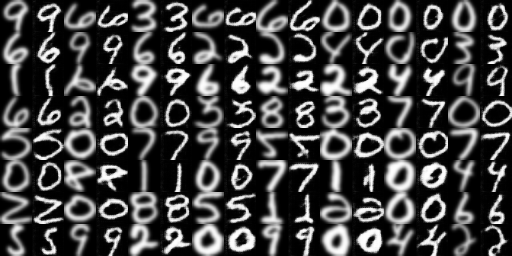

In [45]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-U-M'.format(n_iters) + '.png'))
image

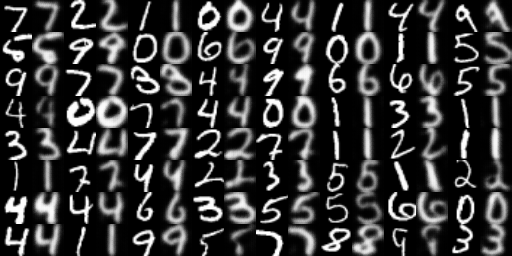

In [46]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-M-U'.format(n_iters) + '.png'))
image

Traning with `use_cycle_consistency_loss = False`.

In [47]:
MNIST_USPS_no_cycle = training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                                    sample_every=1000,  lr=0.0002, train_iters=n_iters, log_step = 100,
                                    use_cycle_consistency_loss=False, opt_name='_no_cycle')

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/ 1000] | d_real_loss: 0.0975 | d_U_loss: 0.1051 | d_M_loss: 0.0861 | d_fake_loss: 0.1912 | g_loss: 0.6905
Saved ./results/sample-001000-M-U_no_cycle.png
Saved ./results/sample-001000-U-M_no_cycle.png


Results :

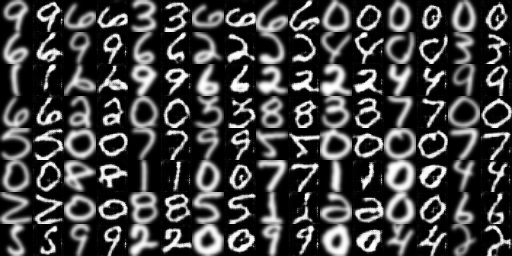

In [48]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-U-M'.format(n_iters) + '_no_cycle.png'))
image

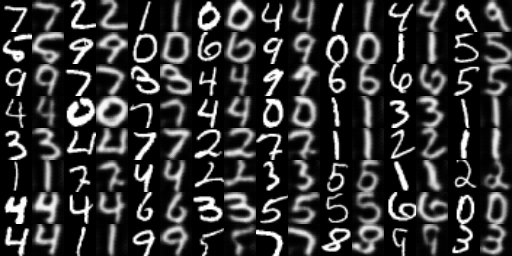

In [49]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-M-U'.format(n_iters) + '_no_cycle.png'))
image

### **Wasserstein modifications**

Let's implement the different modifications suggested by the introductory paper of Wasserstein GAN and apply them to our model. 

The different modifications undertaken are : 
1. Turning the Adam optimizer into the RMS Prop optimizer 

2. We tranform the loss in order for the discriminator to estimate the Wasserstein difference.

3. Clip parameters 

In [0]:
def training_loop_wass(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                       sample_every=1000,  lr=0.0002, train_iters=20000, log_step=10,
                       batch_size=64, use_cycle_consistency_loss=True, cyc_lambda=1,
                       opt_name=''):
    
    dict_result = {}
    dict_result['d_real_loss'] = []
    dict_result['d_loss_u'] = []
    dict_result['d_loss_m'] = []
    dict_result['d_fake_loss'] = []
    dict_result['g_loss'] = []
    dict_result['d_loss'] = []
    
    # Create generators and discriminators
    G_MtoU, G_UtoM, D_M, D_U = create_model()

    g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
    d_m_params = list(D_M.parameters())  # Get discriminator parameters
    d_u_params = list(D_U.parameters())  # Get discriminator parameters

    ################### Modification 1 ####################
    g_optimizer = optim.RMSprop(g_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    d_m_optimizer = optim.RMSprop(d_m_params, lr, alpha=0.99, eps=1e-08,
                                  weight_decay=0, momentum=0, centered=False)
    d_u_optimizer = optim.RMSprop(d_u_params, lr, alpha=0.99, eps=1e-08,
                                  weight_decay=0, momentum=0, centered=False)

    iter_M = iter(M_train_loader)
    iter_U = iter(U_train_loader)

    test_iter_M = iter(M_test_loader)
    test_iter_U = iter(U_test_loader)

    fixed_M = to_var(test_iter_M.next()[0])
    fixed_U = to_var(test_iter_U.next()[0])

    iter_per_epoch = min(len(iter_M), len(iter_U))

    for iteration in range(1, train_iters+1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_M = iter(M_train_loader)
            iter_U = iter(U_train_loader)

        images_M, labels_M = iter_M.next()
        images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

        images_U, labels_U = iter_U.next()
        images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        if iteration < 25 or iteration % 500 == 0:
            Diters = 100
        else:
            Diters = 5

        for _ in range(Diters):

            d_m_optimizer.zero_grad()
            d_u_optimizer.zero_grad()
            
            ################### Modification 2 ####################
            out_M = D_M(images_M) 
            d_real_loss_m = - torch.mean(out_M)

            out_U = D_U(images_U)
            d_real_loss_u = - torch.mean(out_U)

            d_real_loss = d_real_loss_m + d_real_loss_u

            fake_M = G_UtoM(images_U)
            out_M = D_M(fake_M)
            d_fake_loss_m =  torch.mean(out_M) 

            fake_U = G_MtoU(images_M)
            out_U = D_U(fake_U)
            d_fake_loss_u = torch.mean(out_U) 

            d_fake_loss = d_fake_loss_m + d_fake_loss_u

            d_loss = d_real_loss + d_fake_loss

            d_loss_m = d_real_loss_m + d_fake_loss_m
            d_loss_u = d_real_loss_u + d_fake_loss_u

            d_loss_u.backward()
            d_loss_m.backward()

            d_m_optimizer.step()
            d_u_optimizer.step()


            ################### Modification 3 ####################

            # Clipping MNIST Discriminator's parameters 
            for p in D_M.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            # Clipping USPS Discriminator's parameters 
            for p in D_U.parameters():
                p.data.clamp_(-0.01, 0.01)


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        g_optimizer.zero_grad()

        fake_M = G_UtoM(images_U)
        out = D_M(fake_M)
        g_loss = - torch.mean(out)

        if use_cycle_consistency_loss:
            reconstructed_U = G_MtoU(fake_M)
            cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        fake_U = G_MtoU(images_M)
        out = D_U(fake_U)
        g_loss += - torch.mean(out)

        if use_cycle_consistency_loss:
            reconstructed_M = G_UtoM(fake_U)
            cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()

        # Print the log info
        if iteration % log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, train_iters, d_real_loss.item(), d_loss_u.item(),
                    d_loss_m.item(), d_fake_loss.item(), g_loss.item()))
            
        dict_result['d_real_loss'].append(float(to_data(d_real_loss)))
        dict_result['d_loss_u'].append(float(to_data(d_loss_u)))
        dict_result['d_loss_m'].append(float(to_data(d_loss_m)))
        dict_result['d_fake_loss'].append(float(to_data(d_fake_loss)))
        dict_result['g_loss'].append(float(to_data(g_loss)))
        dict_result['d_loss'].append(float(to_data(d_loss)))
        
        # Save the generated samples
        if iteration % sample_every == 0:
            save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=opt_name)

    return dict_result

In [51]:
MNIST_USPS_wass = training_loop_wass(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                                     sample_every=1000,  lr=0.0002, train_iters=n_iters, log_step=100,
                                     use_cycle_consistency_loss=True, cyc_lambda=1, opt_name='_wass')

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/ 1000] | d_real_loss: -1.1079 | d_U_loss: -0.0765 | d_M_loss: -0.1004 | d_fake_loss: 0.9310 | g_loss: -0.8761
Saved ./results/sample-001000-M-U_wass.png
Saved ./results/sample-001000-U-M_wass.png


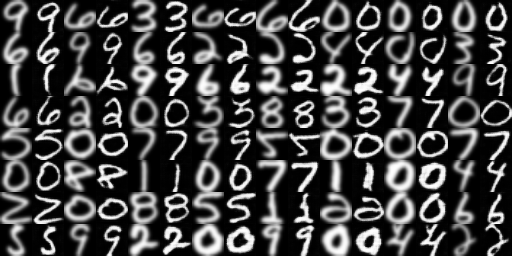

In [52]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-U-M'.format(n_iters) + '_wass.png'))
image

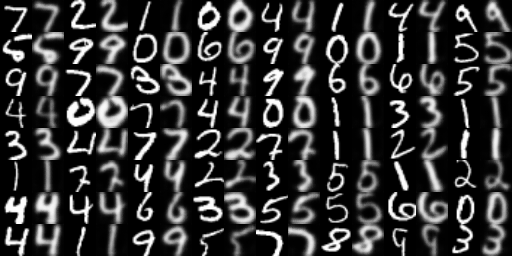

In [53]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-M-U'.format(n_iters) + '_wass.png'))
image

### **Loss analysis**


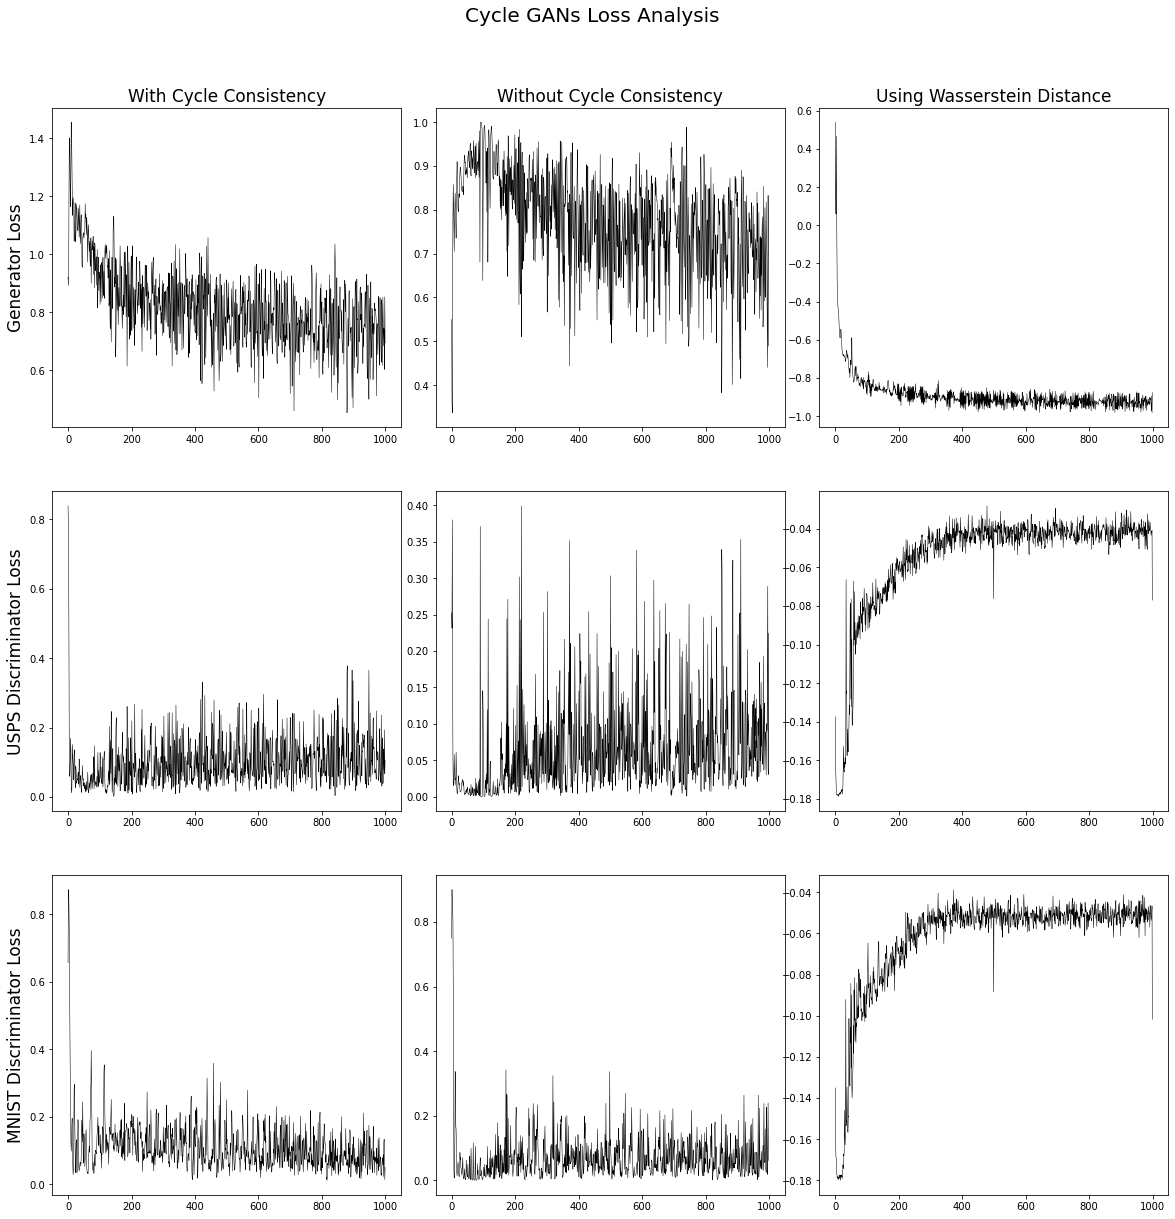

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

axes[0,0].plot(MNIST_USPS['g_loss'], color='black', linewidth=0.5)
axes[0,0].set_title('With Cycle Consistency', fontsize=17)
axes[0,0].set_ylabel("Generator Loss", fontsize=17)
axes[0,1].plot(MNIST_USPS_no_cycle['g_loss'], color='black', linewidth=0.5)
axes[0,1].set_title('Without Cycle Consistency', fontsize=17)
axes[0,2].plot(MNIST_USPS_wass['g_loss'], color='black', linewidth=0.5)
axes[0,2].set_title('Using Wasserstein Distance', fontsize=17)

axes[1,0].plot(MNIST_USPS['D_U_loss'], color='black', linewidth=0.5)
axes[1,0].set_ylabel("USPS Discriminator Loss", fontsize=17)
axes[1,1].plot(MNIST_USPS_no_cycle['D_U_loss'], color='black', linewidth=0.5)
axes[1,2].plot(MNIST_USPS_wass['d_loss_u'], color='black', linewidth=0.5)

axes[2,0].plot(MNIST_USPS['D_M_loss'], color='black', linewidth=0.5)
axes[2,0].set_ylabel("MNIST Discriminator Loss", fontsize=17)
axes[2,1].plot(MNIST_USPS_no_cycle['D_M_loss'], color='black', linewidth=0.5)
axes[2,2].plot(MNIST_USPS_wass['d_loss_m'], color='black', linewidth=0.5)

fig.suptitle('Cycle GANs Loss Analysis', fontsize=20, y=0.95)
fig.subplots_adjust(wspace=0.1)

plt.savefig(os.path.join(RESULTS_PATH, 'loss_analysis.jpg'), optimize=True, quality=95)
plt.show()

## **Cycle-GANs application** : from Apple to Windows

### **Preparing the data** : Apple to Windows

#### Download and construct loaders for Apple and Windows emoticons

In [0]:
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):

    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(data_dir, fname)
    
    print(fpath)

    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {} : {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
            return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

In [46]:
data_fpath = get_file(fname='emojis', 
                      origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz', 
                      untar=True,
                      cache_dir=PATH_DATA)

./data/emojis.tar.gz
Extracting file.


In [0]:
def get_emoji_loader(emoji_type, image_size, batch_size, num_workers):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    img_path = os.path.join('data/emojis', emoji_type)

    dataset = datasets.ImageFolder(img_path, transform)

    dloader = DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

    return dloader

In [0]:
def get_emoji_loader_test(emoji_type, image_size, batch_size, num_workers):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    img_path = os.path.join('data/emojis', emoji_type)

    dataset = datasets.ImageFolder(img_path, transform)

    dloader = DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers)


    return dloader

In [0]:
dataloader_apple = get_emoji_loader("Apple", image_size, batch_size, num_workers)
dataloader_apple_test = get_emoji_loader_test("Test_Apple", image_size, batch_size, num_workers)
dataloader_win = get_emoji_loader("Windows", image_size, batch_size, num_workers)
dataloader_win_test = get_emoji_loader_test("Test_Windows", image_size, batch_size, num_workers)

In [0]:
examples_apple = iter(dataloader_apple)
example_data_apple, _ = next(examples_apple)

examples_win = iter(dataloader_win)
example_data_win, _ = next(examples_win)

In [51]:
example_data_apple.shape, example_data_win.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

#### Visualizing both collections

In [0]:
import matplotlib.pyplot as plt

Apple emojis Collection :


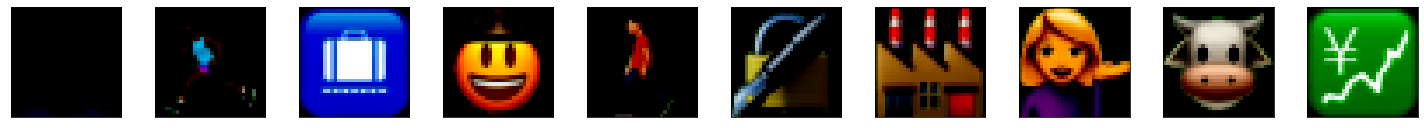

In [53]:
print("Apple emojis Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    np_img = np.transpose(example_data_apple[i].numpy(), (1, 2, 0))
    plt.imshow(np.clip(np_img, 0, 1), interpolation='none')
    plt.xticks([])
    plt.yticks([])

Windows emojis Collection :


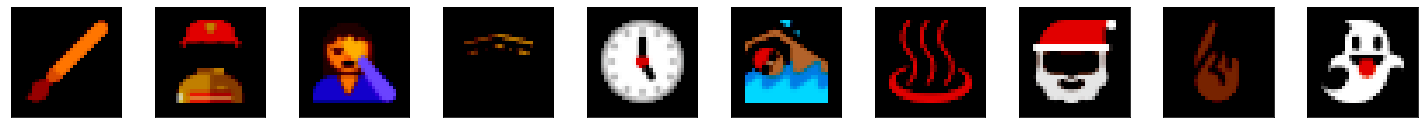

In [54]:
print("Windows emojis Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    np_img = np.transpose(example_data_win[i].numpy(), (1, 2, 0))
    plt.imshow(np.clip(np_img, 0, 1), interpolation='none')
    plt.xticks([])
    plt.yticks([])

### **Model training** 

The model can be reused the same way for emojis, only the discriminator and generator input sizes must be changed to include the coloration layers

In [0]:
class D_(nn.Module):
    """Discriminator for mnist."""

    def __init__(self, conv_dim=64, sigmoid_end=True):
        super(D_, self).__init__()
        self.sigmoid_end = sigmoid_end
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)   
        out = F.leaky_relu(self.conv2(out), 0.05) 
        out = F.leaky_relu(self.conv3(out), 0.05)  
        out = self.fc(out).squeeze()
        if self.sigmoid_end:
          out=torch.sigmoid(out)
        return out

In [0]:
class G_(nn.Module):
    """Generator for transfering from mnist to usps"""
    
    def __init__(self, conv_dim=64):
        super(G_, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      
        out = F.leaky_relu(self.conv2(out), 0.05)   

        out = F.leaky_relu(self.conv3(out), 0.05)   
        out = F.leaky_relu(self.conv4(out), 0.05)    

        out = F.leaky_relu(self.deconv1(out), 0.05) 
        out = torch.tanh(self.deconv2(out))              
        return out


Training with `use_cycle_consistency_loss = True`.

In [59]:
APPLE_WIN = training_loop(dataloader_apple, dataloader_win,
                          get_emoji_loader_test("Test_Apple", image_size, batch_size, num_workers),
                          get_emoji_loader_test("Test_Windows", image_size, batch_size, num_workers),
                          sample_every=5000,  lr=0.0002, train_iters=n_iters*10, log_step = 100,
                          use_cycle_consistency_loss=True, cyc_lambda=1)

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 5000/10000] | d_real_loss: 0.0049 | d_U_loss: 0.0004 | d_M_loss: 0.0109 | d_fake_loss: 0.0113 | g_loss: 1.0454
Saved ./results/sample-005000-M-U.png
Saved ./results/sample-005000-U-M.png
Iteration [ 5100/10000] | d_real_loss: 0.0086 | d_U_loss: 0.0044 | d_M_loss: 0.0212 | d_fake_loss: 0.0256 | g_loss: 1.0197
Iteration [ 5200/10000] | d_real_loss: 0.0081 | d_U_loss: 0.0057 | d_M_loss: 0.0124 | d_fake_loss: 0.0181 | g_loss: 1.0113
Iteration [ 5300/10000] | d_real_loss: 0.0678 | d_U_loss: 0.0070 | d_M_loss: 0.0023 | d_fake_loss: 0.0093 | g_loss: 1.0311
Iteration [ 5400/10000] | d_real_loss: 0.0060 | d_U_loss: 0.0065 | d_M_loss: 0.0217 | d_fake_loss: 0.0283 | g_loss: 0.9704
Iteration [ 5500/10000] | d_real_loss: 0.0197 | d_U_loss: 0.1265 | d_M_loss: 0.0052 | d_fake_loss: 0.1317 | g_loss: 0.9823
Iteration [ 5600/10000] | d_real_loss: 0.0699 | d_U_loss: 0.0019 | d_M_loss: 0.0005 | d_fake_loss: 0.0024 | g_loss: 1.0213
Iteration [ 5700/10000] | d_real_loss: 0.0092 | d_U_loss: 0.001

Iteration [10000/10000] | d_real_loss: 0.0061 | d_U_loss: 0.0019 | d_M_loss: 0.0090 | d_fake_loss: 0.0109 | g_loss: 1.0289
Saved ./results/sample-010000-M-U.png
Saved ./results/sample-010000-U-M.png


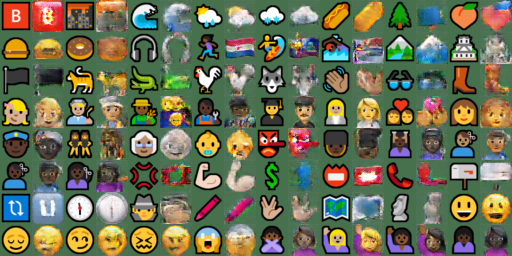

In [61]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-U-M'.format(n_iters*10) + '.png'))
image

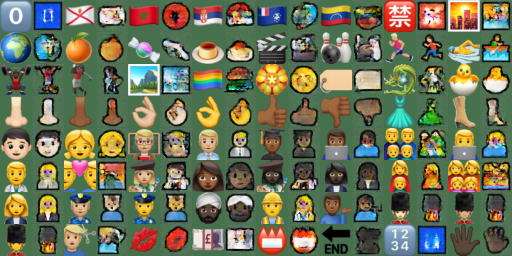

In [63]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-M-U'.format(n_iters*10) + '.png'))
image

Traning with `use_cycle_consistency_loss = False`.

In [64]:
APPLE_WIN_no_cycle = training_loop(dataloader_apple, dataloader_win,
                                   get_emoji_loader_test("Test_Apple", image_size, batch_size, num_workers),
                                   get_emoji_loader_test("Test_Windows", image_size, batch_size, num_workers),
                                   sample_every=1000,  lr=0.0002, train_iters=n_iters*10, log_step = 100,
                                   use_cycle_consistency_loss=False, opt_name='_no_cycle')

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/10000] | d_real_loss: 0.0358 | d_U_loss: 0.0030 | d_M_loss: 0.0312 | d_fake_loss: 0.0342 | g_loss: 0.9588
Saved ./results/sample-001000-M-U_no_cycle.png
Saved ./results/sample-001000-U-M_no_cycle.png
Iteration [ 1100/10000] | d_real_loss: 0.0240 | d_U_loss: 0.0072 | d_M_loss: 0.0038 | d_fake_loss: 0.0110 | g_loss: 0.9412
Iteration [ 1200/10000] | d_real_loss: 0.0233 | d_U_loss: 0.0123 | d_M_loss: 0.0206 | d_fake_loss: 0.0328 | g_loss: 0.9035
Iteration [ 1300/10000] | d_real_loss: 0.0702 | d_U_loss: 0.0089 | d_M_loss: 0.0088 | d_fake_loss: 0.0177 | g_loss: 0.9099
Iteration [ 1400/10000] | d_real_loss: 0.0121 | d_U_loss: 0.0285 | d_M_loss: 0.0401 | d_fake_loss: 0.0687 | g_loss: 0.8790
Iteration [ 1500/10000] | d_real_loss: 0.0710 | d_U_loss: 0.0103 | d_M_loss: 0.0452 | d_fake_loss: 0.0555 | g_loss: 0.9267
Iteration [ 1600/10000] | d_real_loss: 0.0097 | d_U_loss: 0.0018 | d_M_loss: 0.0031 | d_fake_loss: 0.0049 | g_loss: 0.9724
Iteration [ 1700/10000] | d_real_loss: 0.1153

Iteration [ 2000/10000] | d_real_loss: 0.0308 | d_U_loss: 0.0024 | d_M_loss: 0.1288 | d_fake_loss: 0.1312 | g_loss: 0.9780
Saved ./results/sample-002000-M-U_no_cycle.png
Saved ./results/sample-002000-U-M_no_cycle.png
Iteration [ 2100/10000] | d_real_loss: 0.0950 | d_U_loss: 0.0135 | d_M_loss: 0.0135 | d_fake_loss: 0.0270 | g_loss: 0.8865
Iteration [ 2200/10000] | d_real_loss: 0.0127 | d_U_loss: 0.1008 | d_M_loss: 0.0106 | d_fake_loss: 0.1114 | g_loss: 0.8376
Iteration [ 2300/10000] | d_real_loss: 0.0341 | d_U_loss: 0.0286 | d_M_loss: 0.0061 | d_fake_loss: 0.0347 | g_loss: 0.8608
Iteration [ 2400/10000] | d_real_loss: 0.0293 | d_U_loss: 0.0070 | d_M_loss: 0.0069 | d_fake_loss: 0.0139 | g_loss: 0.9244
Iteration [ 2500/10000] | d_real_loss: 0.1759 | d_U_loss: 0.0264 | d_M_loss: 0.0106 | d_fake_loss: 0.0370 | g_loss: 0.7744
Iteration [ 2600/10000] | d_real_loss: 0.0157 | d_U_loss: 0.0091 | d_M_loss: 0.0080 | d_fake_loss: 0.0171 | g_loss: 0.9234
Iteration [ 2700/10000] | d_real_loss: 0.0181

Iteration [ 3000/10000] | d_real_loss: 0.0063 | d_U_loss: 0.0105 | d_M_loss: 0.0085 | d_fake_loss: 0.0189 | g_loss: 0.8494
Saved ./results/sample-003000-M-U_no_cycle.png
Saved ./results/sample-003000-U-M_no_cycle.png
Iteration [ 3100/10000] | d_real_loss: 0.0059 | d_U_loss: 0.0018 | d_M_loss: 0.0143 | d_fake_loss: 0.0162 | g_loss: 0.9649
Iteration [ 3200/10000] | d_real_loss: 0.0412 | d_U_loss: 0.0049 | d_M_loss: 0.0013 | d_fake_loss: 0.0061 | g_loss: 0.8781
Iteration [ 3300/10000] | d_real_loss: 0.0145 | d_U_loss: 0.0248 | d_M_loss: 0.0037 | d_fake_loss: 0.0285 | g_loss: 0.8735
Iteration [ 3400/10000] | d_real_loss: 0.0101 | d_U_loss: 0.0118 | d_M_loss: 0.0053 | d_fake_loss: 0.0171 | g_loss: 0.9341
Iteration [ 3500/10000] | d_real_loss: 0.0472 | d_U_loss: 0.0321 | d_M_loss: 0.0008 | d_fake_loss: 0.0329 | g_loss: 0.8786
Iteration [ 3600/10000] | d_real_loss: 0.0045 | d_U_loss: 0.0062 | d_M_loss: 0.0074 | d_fake_loss: 0.0136 | g_loss: 0.9128
Iteration [ 3700/10000] | d_real_loss: 0.0531

Iteration [ 4000/10000] | d_real_loss: 0.0099 | d_U_loss: 0.0012 | d_M_loss: 0.0002 | d_fake_loss: 0.0013 | g_loss: 0.9847
Saved ./results/sample-004000-M-U_no_cycle.png
Saved ./results/sample-004000-U-M_no_cycle.png
Iteration [ 4100/10000] | d_real_loss: 0.0019 | d_U_loss: 0.0017 | d_M_loss: 0.0041 | d_fake_loss: 0.0058 | g_loss: 0.9692
Iteration [ 4200/10000] | d_real_loss: 0.0013 | d_U_loss: 0.0060 | d_M_loss: 0.0194 | d_fake_loss: 0.0254 | g_loss: 0.9412
Iteration [ 4300/10000] | d_real_loss: 0.0464 | d_U_loss: 0.0146 | d_M_loss: 0.0023 | d_fake_loss: 0.0170 | g_loss: 0.8817
Iteration [ 4400/10000] | d_real_loss: 0.0025 | d_U_loss: 0.0035 | d_M_loss: 0.0125 | d_fake_loss: 0.0159 | g_loss: 0.9436
Iteration [ 4500/10000] | d_real_loss: 0.0240 | d_U_loss: 0.0023 | d_M_loss: 0.0013 | d_fake_loss: 0.0036 | g_loss: 0.9591
Iteration [ 4600/10000] | d_real_loss: 0.0035 | d_U_loss: 0.0023 | d_M_loss: 0.0017 | d_fake_loss: 0.0039 | g_loss: 0.9562
Iteration [ 4700/10000] | d_real_loss: 0.0056

Iteration [ 5000/10000] | d_real_loss: 0.0119 | d_U_loss: 0.0011 | d_M_loss: 0.0128 | d_fake_loss: 0.0139 | g_loss: 0.9685
Saved ./results/sample-005000-M-U_no_cycle.png
Saved ./results/sample-005000-U-M_no_cycle.png
Iteration [ 5100/10000] | d_real_loss: 0.0104 | d_U_loss: 0.0009 | d_M_loss: 0.0163 | d_fake_loss: 0.0172 | g_loss: 0.9668
Iteration [ 5200/10000] | d_real_loss: 0.0737 | d_U_loss: 0.0006 | d_M_loss: 0.0004 | d_fake_loss: 0.0010 | g_loss: 0.9767
Iteration [ 5300/10000] | d_real_loss: 0.0104 | d_U_loss: 0.0040 | d_M_loss: 0.0236 | d_fake_loss: 0.0276 | g_loss: 0.9798
Iteration [ 5400/10000] | d_real_loss: 0.0027 | d_U_loss: 0.0011 | d_M_loss: 0.0036 | d_fake_loss: 0.0047 | g_loss: 0.9786
Iteration [ 5500/10000] | d_real_loss: 0.0008 | d_U_loss: 0.0046 | d_M_loss: 0.0022 | d_fake_loss: 0.0069 | g_loss: 0.9438
Iteration [ 5600/10000] | d_real_loss: 0.0733 | d_U_loss: 0.0022 | d_M_loss: 0.0081 | d_fake_loss: 0.0104 | g_loss: 0.9680
Iteration [ 5700/10000] | d_real_loss: 0.0150

Iteration [ 6000/10000] | d_real_loss: 0.0096 | d_U_loss: 0.0104 | d_M_loss: 0.0148 | d_fake_loss: 0.0253 | g_loss: 0.9399
Saved ./results/sample-006000-M-U_no_cycle.png
Saved ./results/sample-006000-U-M_no_cycle.png
Iteration [ 6100/10000] | d_real_loss: 0.0017 | d_U_loss: 0.0133 | d_M_loss: 0.0024 | d_fake_loss: 0.0156 | g_loss: 0.9350
Iteration [ 6200/10000] | d_real_loss: 0.0163 | d_U_loss: 0.0233 | d_M_loss: 0.0002 | d_fake_loss: 0.0234 | g_loss: 0.9370
Iteration [ 6300/10000] | d_real_loss: 0.0105 | d_U_loss: 0.0013 | d_M_loss: 0.0097 | d_fake_loss: 0.0110 | g_loss: 0.9658
Iteration [ 6400/10000] | d_real_loss: 0.0016 | d_U_loss: 0.0044 | d_M_loss: 0.0035 | d_fake_loss: 0.0079 | g_loss: 0.9474
Iteration [ 6500/10000] | d_real_loss: 0.0308 | d_U_loss: 0.0005 | d_M_loss: 0.0008 | d_fake_loss: 0.0013 | g_loss: 0.9878
Iteration [ 6600/10000] | d_real_loss: 0.0077 | d_U_loss: 0.0042 | d_M_loss: 0.0031 | d_fake_loss: 0.0073 | g_loss: 0.9766
Iteration [ 6700/10000] | d_real_loss: 0.0327

Iteration [ 7000/10000] | d_real_loss: 0.0364 | d_U_loss: 0.0031 | d_M_loss: 0.0007 | d_fake_loss: 0.0038 | g_loss: 0.9463
Saved ./results/sample-007000-M-U_no_cycle.png
Saved ./results/sample-007000-U-M_no_cycle.png
Iteration [ 7100/10000] | d_real_loss: 0.0014 | d_U_loss: 0.0074 | d_M_loss: 0.0395 | d_fake_loss: 0.0469 | g_loss: 0.9565
Iteration [ 7200/10000] | d_real_loss: 0.0107 | d_U_loss: 0.0012 | d_M_loss: 0.0020 | d_fake_loss: 0.0031 | g_loss: 0.9621
Iteration [ 7300/10000] | d_real_loss: 0.0054 | d_U_loss: 0.0046 | d_M_loss: 0.0018 | d_fake_loss: 0.0064 | g_loss: 0.9629
Iteration [ 7400/10000] | d_real_loss: 0.0002 | d_U_loss: 0.0064 | d_M_loss: 0.0577 | d_fake_loss: 0.0642 | g_loss: 0.9517
Iteration [ 7500/10000] | d_real_loss: 0.0036 | d_U_loss: 0.0009 | d_M_loss: 0.0244 | d_fake_loss: 0.0253 | g_loss: 0.9702
Iteration [ 7600/10000] | d_real_loss: 0.0068 | d_U_loss: 0.0006 | d_M_loss: 0.0060 | d_fake_loss: 0.0065 | g_loss: 0.9849
Iteration [ 7700/10000] | d_real_loss: 0.0047

Iteration [ 8000/10000] | d_real_loss: 0.0032 | d_U_loss: 0.0026 | d_M_loss: 0.0081 | d_fake_loss: 0.0106 | g_loss: 0.9689
Saved ./results/sample-008000-M-U_no_cycle.png
Saved ./results/sample-008000-U-M_no_cycle.png
Iteration [ 8100/10000] | d_real_loss: 0.0007 | d_U_loss: 0.0201 | d_M_loss: 0.0593 | d_fake_loss: 0.0794 | g_loss: 0.9179
Iteration [ 8200/10000] | d_real_loss: 0.0320 | d_U_loss: 0.0011 | d_M_loss: 0.0014 | d_fake_loss: 0.0025 | g_loss: 0.9721
Iteration [ 8300/10000] | d_real_loss: 0.0359 | d_U_loss: 0.0001 | d_M_loss: 0.0018 | d_fake_loss: 0.0019 | g_loss: 0.9828
Iteration [ 8400/10000] | d_real_loss: 0.0080 | d_U_loss: 0.0022 | d_M_loss: 0.0030 | d_fake_loss: 0.0052 | g_loss: 0.9597
Iteration [ 8500/10000] | d_real_loss: 0.0053 | d_U_loss: 0.0044 | d_M_loss: 0.0017 | d_fake_loss: 0.0060 | g_loss: 0.9302
Iteration [ 8600/10000] | d_real_loss: 0.0068 | d_U_loss: 0.0017 | d_M_loss: 0.1178 | d_fake_loss: 0.1195 | g_loss: 0.9769
Iteration [ 8700/10000] | d_real_loss: 0.0273

Iteration [ 9000/10000] | d_real_loss: 0.0014 | d_U_loss: 0.0072 | d_M_loss: 0.0086 | d_fake_loss: 0.0158 | g_loss: 0.9238
Saved ./results/sample-009000-M-U_no_cycle.png
Saved ./results/sample-009000-U-M_no_cycle.png
Iteration [ 9100/10000] | d_real_loss: 0.0182 | d_U_loss: 0.0004 | d_M_loss: 0.0031 | d_fake_loss: 0.0035 | g_loss: 0.9813
Iteration [ 9200/10000] | d_real_loss: 0.0006 | d_U_loss: 0.0121 | d_M_loss: 0.0037 | d_fake_loss: 0.0157 | g_loss: 0.8872
Iteration [ 9300/10000] | d_real_loss: 0.0186 | d_U_loss: 0.0007 | d_M_loss: 0.0023 | d_fake_loss: 0.0029 | g_loss: 0.9784
Iteration [ 9400/10000] | d_real_loss: 0.0858 | d_U_loss: 0.0091 | d_M_loss: 0.0004 | d_fake_loss: 0.0095 | g_loss: 0.9392
Iteration [ 9500/10000] | d_real_loss: 0.0013 | d_U_loss: 0.0038 | d_M_loss: 0.0005 | d_fake_loss: 0.0043 | g_loss: 0.9496
Iteration [ 9600/10000] | d_real_loss: 0.0028 | d_U_loss: 0.0033 | d_M_loss: 0.0003 | d_fake_loss: 0.0036 | g_loss: 0.9461
Iteration [ 9700/10000] | d_real_loss: 0.0137

Iteration [10000/10000] | d_real_loss: 0.0052 | d_U_loss: 0.0019 | d_M_loss: 0.0048 | d_fake_loss: 0.0066 | g_loss: 0.9755
Saved ./results/sample-010000-M-U_no_cycle.png
Saved ./results/sample-010000-U-M_no_cycle.png


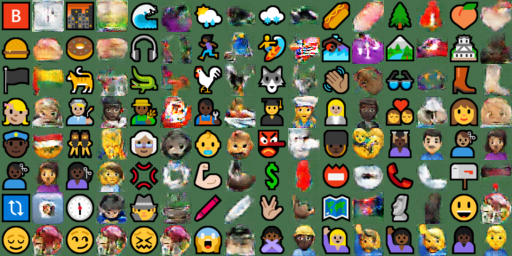

In [66]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-U-M'.format(n_iters*10) + '_no_cycle.png'))
image

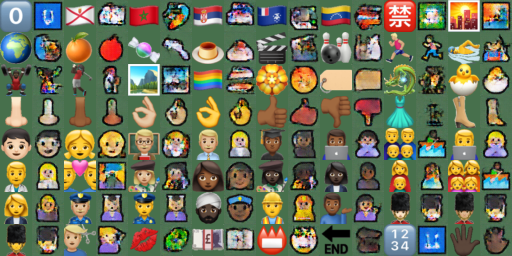

In [67]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-M-U'.format(n_iters*10) + '_no_cycle.png'))
image

Traning the Wasserstein model : `use_cycle_consistency_loss = True`.

In [68]:
APPLE_WIN_wass = training_loop_wass(dataloader_apple, dataloader_win,
                                    get_emoji_loader_test("Test_Apple", image_size, batch_size, num_workers),
                                    get_emoji_loader_test("Test_Windows", image_size, batch_size, num_workers),
                                    sample_every=1000,  lr=0.0002, train_iters=n_iters*10, log_step=100,
                                    use_cycle_consistency_loss=True, opt_name='_wass')

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/10000] | d_real_loss: -1.1392 | d_U_loss: -0.1396 | d_M_loss: -0.1386 | d_fake_loss: 0.8609 | g_loss: -0.8105
Saved ./results/sample-001000-M-U_wass.png
Saved ./results/sample-001000-U-M_wass.png
Iteration [ 1100/10000] | d_real_loss: -1.0788 | d_U_loss: -0.0803 | d_M_loss: -0.0770 | d_fake_loss: 0.9215 | g_loss: -0.8652
Iteration [ 1200/10000] | d_real_loss: -1.0832 | d_U_loss: -0.0888 | d_M_loss: -0.0845 | d_fake_loss: 0.9099 | g_loss: -0.8643
Iteration [ 1300/10000] | d_real_loss: -1.0586 | d_U_loss: -0.0869 | d_M_loss: -0.0857 | d_fake_loss: 0.8861 | g_loss: -0.8960
Iteration [ 1400/10000] | d_real_loss: -1.1048 | d_U_loss: -0.0868 | d_M_loss: -0.0907 | d_fake_loss: 0.9273 | g_loss: -0.8524
Iteration [ 1500/10000] | d_real_loss: -1.1423 | d_U_loss: -0.1374 | d_M_loss: -0.1420 | d_fake_loss: 0.8630 | g_loss: -0.8139
Iteration [ 1600/10000] | d_real_loss: -1.0682 | d_U_loss: -0.0724 | d_M_loss: -0.0801 | d_fake_loss: 0.9157 | g_loss: -0.8717
Iteration [ 1700/10000] |

Iteration [ 2000/10000] | d_real_loss: -1.1339 | d_U_loss: -0.1362 | d_M_loss: -0.1322 | d_fake_loss: 0.8655 | g_loss: -0.8322
Saved ./results/sample-002000-M-U_wass.png
Saved ./results/sample-002000-U-M_wass.png
Iteration [ 2100/10000] | d_real_loss: -1.0739 | d_U_loss: -0.0867 | d_M_loss: -0.0839 | d_fake_loss: 0.9033 | g_loss: -0.8816
Iteration [ 2200/10000] | d_real_loss: -1.0450 | d_U_loss: -0.0869 | d_M_loss: -0.0756 | d_fake_loss: 0.8825 | g_loss: -0.9124
Iteration [ 2300/10000] | d_real_loss: -1.0826 | d_U_loss: -0.0899 | d_M_loss: -0.0795 | d_fake_loss: 0.9131 | g_loss: -0.8757
Iteration [ 2400/10000] | d_real_loss: -1.0952 | d_U_loss: -0.0861 | d_M_loss: -0.0819 | d_fake_loss: 0.9271 | g_loss: -0.8628
Iteration [ 2500/10000] | d_real_loss: -1.1385 | d_U_loss: -0.1380 | d_M_loss: -0.1337 | d_fake_loss: 0.8667 | g_loss: -0.8289
Iteration [ 2600/10000] | d_real_loss: -1.0771 | d_U_loss: -0.0829 | d_M_loss: -0.0746 | d_fake_loss: 0.9196 | g_loss: -0.8824
Iteration [ 2700/10000] |

Iteration [ 3000/10000] | d_real_loss: -1.1340 | d_U_loss: -0.1381 | d_M_loss: -0.1345 | d_fake_loss: 0.8614 | g_loss: -0.8327
Saved ./results/sample-003000-M-U_wass.png
Saved ./results/sample-003000-U-M_wass.png
Iteration [ 3100/10000] | d_real_loss: -1.0706 | d_U_loss: -0.0861 | d_M_loss: -0.0771 | d_fake_loss: 0.9073 | g_loss: -0.8936
Iteration [ 3200/10000] | d_real_loss: -1.1029 | d_U_loss: -0.0891 | d_M_loss: -0.0901 | d_fake_loss: 0.9236 | g_loss: -0.8477
Iteration [ 3300/10000] | d_real_loss: -1.0782 | d_U_loss: -0.0919 | d_M_loss: -0.0753 | d_fake_loss: 0.9111 | g_loss: -0.8886
Iteration [ 3400/10000] | d_real_loss: -1.0480 | d_U_loss: -0.0845 | d_M_loss: -0.0733 | d_fake_loss: 0.8902 | g_loss: -0.9181
Iteration [ 3500/10000] | d_real_loss: -1.1395 | d_U_loss: -0.1352 | d_M_loss: -0.1384 | d_fake_loss: 0.8658 | g_loss: -0.8264
Iteration [ 3600/10000] | d_real_loss: -1.0396 | d_U_loss: -0.0872 | d_M_loss: -0.0703 | d_fake_loss: 0.8821 | g_loss: -0.9296
Iteration [ 3700/10000] |

Iteration [ 4000/10000] | d_real_loss: -1.1427 | d_U_loss: -0.1438 | d_M_loss: -0.1361 | d_fake_loss: 0.8629 | g_loss: -0.8252
Saved ./results/sample-004000-M-U_wass.png
Saved ./results/sample-004000-U-M_wass.png
Iteration [ 4100/10000] | d_real_loss: -1.0859 | d_U_loss: -0.0880 | d_M_loss: -0.0768 | d_fake_loss: 0.9211 | g_loss: -0.8774
Iteration [ 4200/10000] | d_real_loss: -1.0769 | d_U_loss: -0.0771 | d_M_loss: -0.0790 | d_fake_loss: 0.9208 | g_loss: -0.8816
Iteration [ 4300/10000] | d_real_loss: -1.0752 | d_U_loss: -0.0845 | d_M_loss: -0.0720 | d_fake_loss: 0.9187 | g_loss: -0.8941
Iteration [ 4400/10000] | d_real_loss: -1.1083 | d_U_loss: -0.0848 | d_M_loss: -0.0808 | d_fake_loss: 0.9428 | g_loss: -0.8516
Iteration [ 4500/10000] | d_real_loss: -1.1348 | d_U_loss: -0.1393 | d_M_loss: -0.1330 | d_fake_loss: 0.8626 | g_loss: -0.8337
Iteration [ 4600/10000] | d_real_loss: -1.0751 | d_U_loss: -0.0841 | d_M_loss: -0.0736 | d_fake_loss: 0.9173 | g_loss: -0.8906
Iteration [ 4700/10000] |

Iteration [ 5000/10000] | d_real_loss: -1.1348 | d_U_loss: -0.1370 | d_M_loss: -0.1361 | d_fake_loss: 0.8617 | g_loss: -0.8358
Saved ./results/sample-005000-M-U_wass.png
Saved ./results/sample-005000-U-M_wass.png
Iteration [ 5100/10000] | d_real_loss: -1.0889 | d_U_loss: -0.0819 | d_M_loss: -0.0763 | d_fake_loss: 0.9307 | g_loss: -0.8790
Iteration [ 5200/10000] | d_real_loss: -1.0850 | d_U_loss: -0.0863 | d_M_loss: -0.0848 | d_fake_loss: 0.9139 | g_loss: -0.8812
Iteration [ 5300/10000] | d_real_loss: -1.0968 | d_U_loss: -0.0887 | d_M_loss: -0.0823 | d_fake_loss: 0.9257 | g_loss: -0.8622
Iteration [ 5400/10000] | d_real_loss: -1.0980 | d_U_loss: -0.0856 | d_M_loss: -0.0808 | d_fake_loss: 0.9316 | g_loss: -0.8599
Iteration [ 5500/10000] | d_real_loss: -1.1383 | d_U_loss: -0.1362 | d_M_loss: -0.1361 | d_fake_loss: 0.8660 | g_loss: -0.8305
Iteration [ 5600/10000] | d_real_loss: -1.0818 | d_U_loss: -0.0877 | d_M_loss: -0.0795 | d_fake_loss: 0.9145 | g_loss: -0.8820
Iteration [ 5700/10000] |

Iteration [ 6000/10000] | d_real_loss: -1.1375 | d_U_loss: -0.1402 | d_M_loss: -0.1351 | d_fake_loss: 0.8622 | g_loss: -0.8373
Saved ./results/sample-006000-M-U_wass.png
Saved ./results/sample-006000-U-M_wass.png
Iteration [ 6100/10000] | d_real_loss: -1.0873 | d_U_loss: -0.0897 | d_M_loss: -0.0777 | d_fake_loss: 0.9199 | g_loss: -0.8759
Iteration [ 6200/10000] | d_real_loss: -1.0775 | d_U_loss: -0.0880 | d_M_loss: -0.0718 | d_fake_loss: 0.9177 | g_loss: -0.8909
Iteration [ 6300/10000] | d_real_loss: -1.1072 | d_U_loss: -0.0785 | d_M_loss: -0.0641 | d_fake_loss: 0.9646 | g_loss: -0.8487
Iteration [ 6400/10000] | d_real_loss: -1.0882 | d_U_loss: -0.0922 | d_M_loss: -0.0771 | d_fake_loss: 0.9189 | g_loss: -0.8826
Iteration [ 6500/10000] | d_real_loss: -1.1429 | d_U_loss: -0.1387 | d_M_loss: -0.1389 | d_fake_loss: 0.8653 | g_loss: -0.8279
Iteration [ 6600/10000] | d_real_loss: -1.0534 | d_U_loss: -0.0804 | d_M_loss: -0.0851 | d_fake_loss: 0.8879 | g_loss: -0.9260
Iteration [ 6700/10000] |

Iteration [ 7000/10000] | d_real_loss: -1.1346 | d_U_loss: -0.1383 | d_M_loss: -0.1374 | d_fake_loss: 0.8590 | g_loss: -0.8373
Saved ./results/sample-007000-M-U_wass.png
Saved ./results/sample-007000-U-M_wass.png
Iteration [ 7100/10000] | d_real_loss: -1.0767 | d_U_loss: -0.0834 | d_M_loss: -0.0715 | d_fake_loss: 0.9218 | g_loss: -0.8924
Iteration [ 7200/10000] | d_real_loss: -1.0724 | d_U_loss: -0.0869 | d_M_loss: -0.0720 | d_fake_loss: 0.9135 | g_loss: -0.9041
Iteration [ 7300/10000] | d_real_loss: -1.1045 | d_U_loss: -0.0769 | d_M_loss: -0.0818 | d_fake_loss: 0.9458 | g_loss: -0.8584
Iteration [ 7400/10000] | d_real_loss: -1.0785 | d_U_loss: -0.0840 | d_M_loss: -0.0797 | d_fake_loss: 0.9148 | g_loss: -0.8886
Iteration [ 7500/10000] | d_real_loss: -1.1360 | d_U_loss: -0.1413 | d_M_loss: -0.1366 | d_fake_loss: 0.8581 | g_loss: -0.8393
Iteration [ 7600/10000] | d_real_loss: -1.0692 | d_U_loss: -0.0806 | d_M_loss: -0.0725 | d_fake_loss: 0.9161 | g_loss: -0.9074
Iteration [ 7700/10000] |

Iteration [ 8000/10000] | d_real_loss: -1.1417 | d_U_loss: -0.1411 | d_M_loss: -0.1395 | d_fake_loss: 0.8611 | g_loss: -0.8266
Saved ./results/sample-008000-M-U_wass.png
Saved ./results/sample-008000-U-M_wass.png
Iteration [ 8100/10000] | d_real_loss: -1.0627 | d_U_loss: -0.0756 | d_M_loss: -0.0814 | d_fake_loss: 0.9057 | g_loss: -0.9009
Iteration [ 8200/10000] | d_real_loss: -1.0704 | d_U_loss: -0.0860 | d_M_loss: -0.0728 | d_fake_loss: 0.9117 | g_loss: -0.9054
Iteration [ 8300/10000] | d_real_loss: -1.0667 | d_U_loss: -0.0837 | d_M_loss: -0.0781 | d_fake_loss: 0.9049 | g_loss: -0.9091
Iteration [ 8400/10000] | d_real_loss: -1.0781 | d_U_loss: -0.0796 | d_M_loss: -0.0692 | d_fake_loss: 0.9293 | g_loss: -0.8894
Iteration [ 8500/10000] | d_real_loss: -1.1407 | d_U_loss: -0.1427 | d_M_loss: -0.1379 | d_fake_loss: 0.8601 | g_loss: -0.8334
Iteration [ 8600/10000] | d_real_loss: -1.0955 | d_U_loss: -0.0864 | d_M_loss: -0.0771 | d_fake_loss: 0.9321 | g_loss: -0.8709
Iteration [ 8700/10000] |

Iteration [ 9000/10000] | d_real_loss: -1.1413 | d_U_loss: -0.1421 | d_M_loss: -0.1386 | d_fake_loss: 0.8606 | g_loss: -0.8315
Saved ./results/sample-009000-M-U_wass.png
Saved ./results/sample-009000-U-M_wass.png
Iteration [ 9100/10000] | d_real_loss: -1.0711 | d_U_loss: -0.0871 | d_M_loss: -0.0744 | d_fake_loss: 0.9096 | g_loss: -0.8998
Iteration [ 9200/10000] | d_real_loss: -1.1084 | d_U_loss: -0.0775 | d_M_loss: -0.0723 | d_fake_loss: 0.9586 | g_loss: -0.8538
Iteration [ 9300/10000] | d_real_loss: -1.0581 | d_U_loss: -0.0840 | d_M_loss: -0.0754 | d_fake_loss: 0.8986 | g_loss: -0.9229
Iteration [ 9400/10000] | d_real_loss: -1.0667 | d_U_loss: -0.0825 | d_M_loss: -0.0708 | d_fake_loss: 0.9135 | g_loss: -0.9081
Iteration [ 9500/10000] | d_real_loss: -1.1417 | d_U_loss: -0.1386 | d_M_loss: -0.1381 | d_fake_loss: 0.8650 | g_loss: -0.8353
Iteration [ 9600/10000] | d_real_loss: -1.0754 | d_U_loss: -0.0841 | d_M_loss: -0.0835 | d_fake_loss: 0.9078 | g_loss: -0.8940
Iteration [ 9700/10000] |

Iteration [10000/10000] | d_real_loss: -1.1369 | d_U_loss: -0.1395 | d_M_loss: -0.1367 | d_fake_loss: 0.8607 | g_loss: -0.8382
Saved ./results/sample-010000-M-U_wass.png
Saved ./results/sample-010000-U-M_wass.png


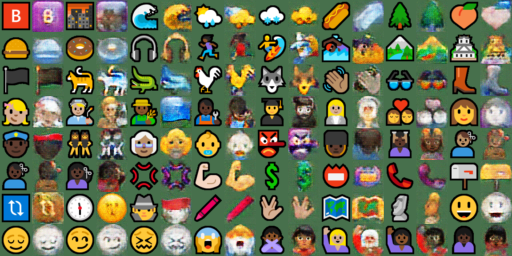

In [69]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-U-M'.format(n_iters*10) + '_wass.png'))
image

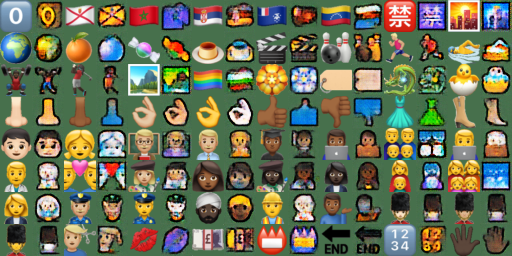

In [70]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-M-U'.format(n_iters*10) + '_wass.png'))
image

### **Loss analysis**

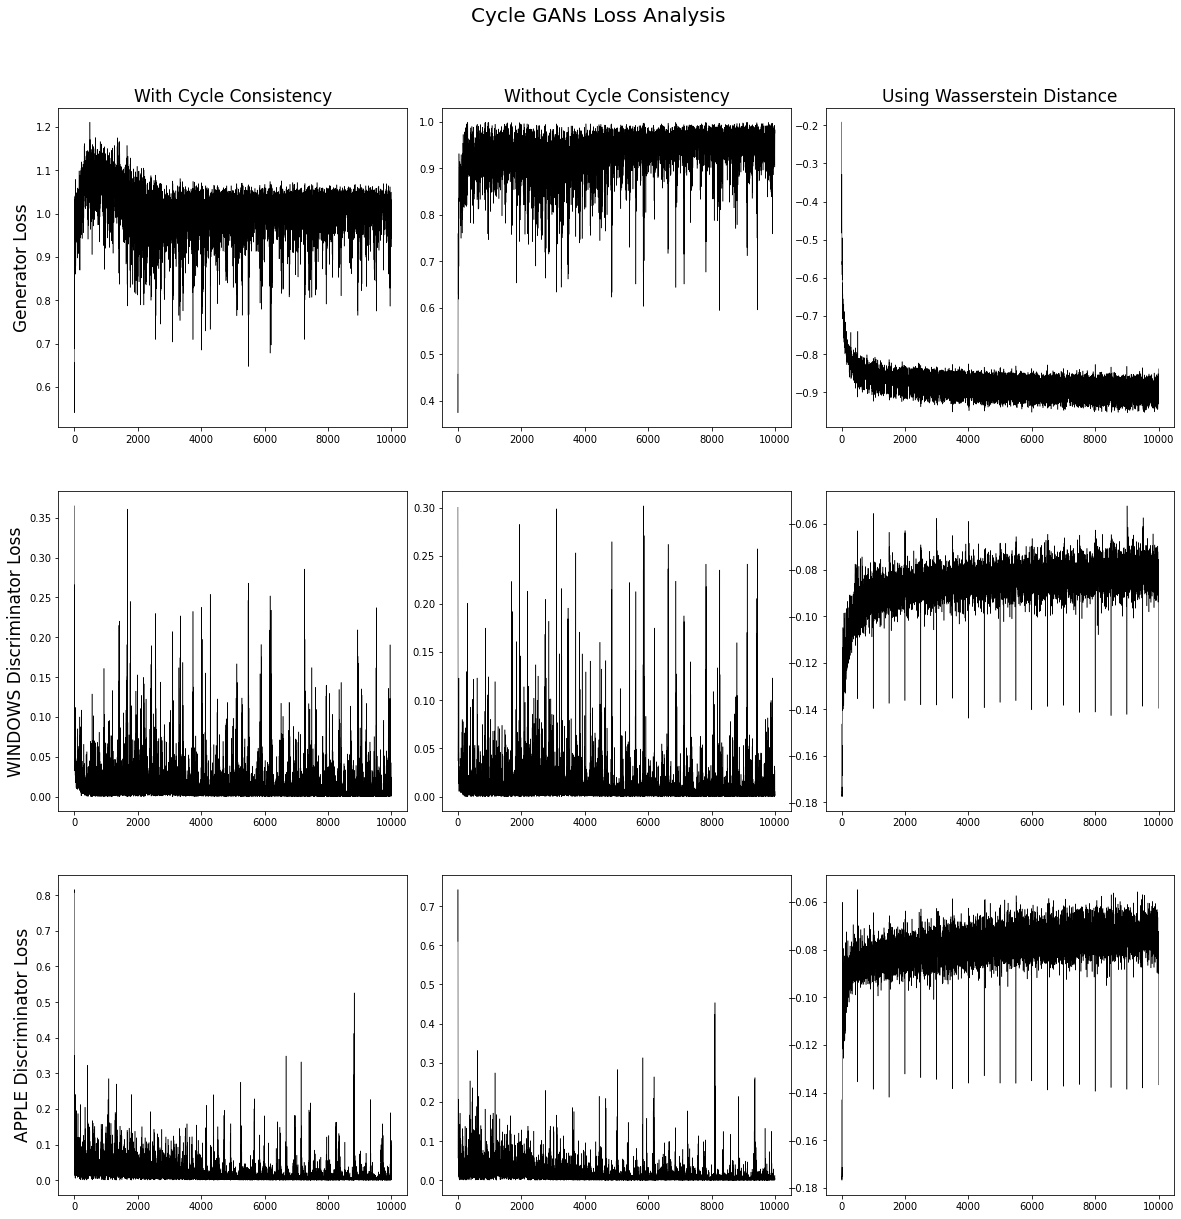

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

axes[0,0].plot(APPLE_WIN['g_loss'], color='black', linewidth=0.5)
axes[0,0].set_title('With Cycle Consistency', fontsize=17)
axes[0,0].set_ylabel("Generator Loss", fontsize=17)
axes[0,1].plot(APPLE_WIN_no_cycle['g_loss'], color='black', linewidth=0.5)
axes[0,1].set_title('Without Cycle Consistency', fontsize=17)
axes[0,2].plot(APPLE_WIN_wass['g_loss'], color='black', linewidth=0.5)
axes[0,2].set_title('Using Wasserstein Distance', fontsize=17)

axes[1,0].plot(APPLE_WIN['D_U_loss'], color='black', linewidth=0.5)
axes[1,0].set_ylabel("WINDOWS Discriminator Loss", fontsize=17)
axes[1,1].plot(APPLE_WIN_no_cycle['D_U_loss'], color='black', linewidth=0.5)
axes[1,2].plot(APPLE_WIN_wass['d_loss_u'], color='black', linewidth=0.5)

axes[2,0].plot(APPLE_WIN['D_M_loss'], color='black', linewidth=0.5)
axes[2,0].set_ylabel("APPLE Discriminator Loss", fontsize=17)
axes[2,1].plot(APPLE_WIN_no_cycle['D_M_loss'], color='black', linewidth=0.5)
axes[2,2].plot(APPLE_WIN_wass['d_loss_m'], color='black', linewidth=0.5)

fig.suptitle('Cycle GANs Loss Analysis', fontsize=20, y=0.95)
fig.subplots_adjust(wspace=0.1)

plt.savefig(os.path.join(RESULTS_PATH, 'loss_analysis.jpg'), optimize=True, quality=95)
plt.show()